# Homework 3
## Problem 4
(A) Using transport of measure, simulate samples from p(x)

In [1]:
# libs
import numpy as np
from numpy import random
from matplotlib import pylab as plt

# define transport, note that x must be in (0,1)
def T(x):
    return x**2

In [2]:
# take N = 10e4 samples from Uniform(0,1)
x = random.uniform(0,1,int(10e4))
# transport to p(x)
y = T(x)

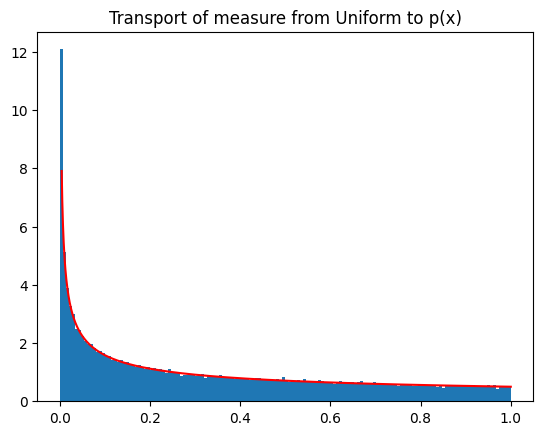

In [88]:
# plot samples
plt.hist(y, bins = 150, density=True)

# plot analytical p(x)
line_x = np.linspace(0.004, 1, 10000)
line_y = 1/(2*np.sqrt(line_x))
plt.plot(line_x,line_y, color='red')
plt.title('Transport of measure from Uniform to p(x)')

# show
plt.show()

(B) Rejection sampling estimation of g (above) using f: Beta(alpha=2, beta=5) on (0,1)

In [4]:
# libs
import numpy as np
from numpy import random
from scipy.stats import beta
from matplotlib import pylab as plt

In [5]:
# define the transportation T(x) for Uniform --> g
def T(x):
    return x**2

# define target f(x)
def f(x): return beta.pdf(x, a=2, b=5)

# define proposal g(x)
def g(x): 
    if (x <= 0 or x > 1): return 0 
    else: return 1/(2*np.sqrt(x))


In [6]:
# Finding the appropriate M value (max of the ratio)
M = max([f(z)/g(z) for z in np.linspace(0.00001, 1, 10000)])
print(M)

2.390745305938473


In [7]:
# Let's set M = 2.4
def rejection_sample(f=f, g=g, T=T, M=2.4):
    b = True
    while b:
        # use measure transportation to sample from g
        Z = T(random.uniform(0,1))
        # sample uniform on 0,1
        U = random.uniform(0,1)
        if (M*U) <= (f(Z)/g(Z)):
            X = Z
            b = False
    return X


In [8]:
# get N = 10e4 samples
samples = np.array([rejection_sample() for i in range(int(10e4))])

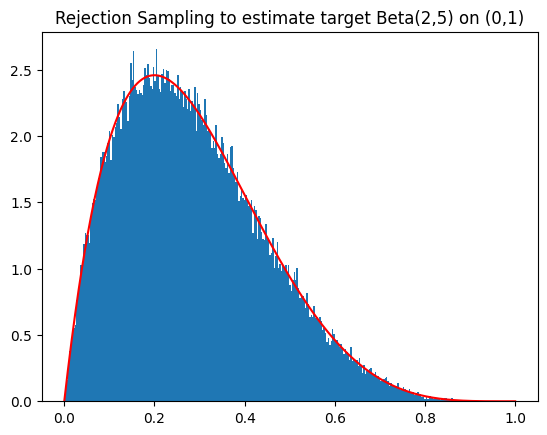

In [89]:
# plot our rejection samples
plt.hist(samples, bins = 300, density=True)

# plot the analytical beta distribution
x_line = np.linspace(0,1,1000)
y_line = f(x_line)
plt.plot(x_line,y_line,color='red')
plt.title("Rejection Sampling to estimate target Beta(2,5) on (0,1)")

# show
plt.show()

## Problem 5

(A) Estimate the integral of h(x) over the range [0,1]^d using samples from f(x) which is uniform over [0,1]^d using Monte Carlo, for d=100

In [10]:
# Given that each coordinate of the uniform distribution is independent, 
# we can sample a single point as d uniform coordinates

In [11]:
import numpy as np
from numpy import random

def h(x):
    '''
    @input
    x: an array of d=100 points
    @output
    the scalar map h:[0,1]^100 --> R evaluated at X
    '''
    if len(x) != 100: raise ValueError('x not in d=100')
    out = np.abs( np.sin( 2*np.pi * x[0] * np.sum(x) ) ) * ( np.cos( 2*np.pi * x[1] * np.sum(x**2) ) **2 ) 
    return out


def estimate(N, h=h):
    # sample N sets of 100 uniform coordinates in [0,1]
    X = random.uniform(0,1,N*100).reshape(N, 100)
    # pass each row through h
    h_X = np.array([h(x) for x in X])
    return (np.sum(h_X)/N)

In [12]:
# calculate the expectation (integral over E on h(X))
E_hx = estimate(N=int(10e6))
print(E_hx) # 0.31834905816043185

0.31839031235309606


In [13]:
# estimate variance or E[h(X)^2] - E[h(X)]^2
def h2(x):
    return (h(x)**2)
E_hx2 = estimate(N=int(10e6), h=h2)
Var_hx = E_hx2 - (E_hx**2)
print(Var_hx) # 0.08604133902562666

0.08606238248368911


In [14]:
# let N=100 and estimate E[MC-estimator] by averaging over M = 1000 realizations
N=100
M=1000
ests = np.zeros(M)
for i in np.arange(0,M):
    ests[i] = estimate(N=N)

E_estimator = (np.sum(ests)/M)
print(E_estimator) # 0.318838606910475

0.31752052843820117


In [15]:
# Let N = 100 and M = 1000. 
# Estimate Var[MC-estimator] = Estimating MC-estimator(h^2) - Estimating (MC-estimator(h))^2
N=100
M=1000
v_ests = np.zeros(M)
for i in np.arange(0,M):
    v_ests[i] = estimate(N=N, h=h2) - (estimate(N=N, h=h)**2)

V_estimator = (np.sum(v_ests)/M)
print(V_estimator)

0.08494236218240811


## Problem 6
Estimate the target p = P[X > 4], X ~ N(0,1) using 

* classic Monte Carlo __and__ 

* Importance Sampling with proposal distribution g as Exp(1) right shifted by 4
* `w(x) = f(x)/g(x) = ( 1/np.sqrt(2*np.pi) ) * np.exp((-0.5 * x**2) + (x-4))`


In [139]:
# (i) classic Monte Carlo
import numpy as np
from numpy import random

def h(x):
    '''
    @input
    x: an array of n samples
    @output
    an array of x evaluated at the identity x > 4
    '''
    return (x > 4).astype(int)

def mc_estimate(N, h=h):
    # sample N normal points
    X = random.normal(0,1,N)
    # evaluate for h
    h_X = h(X)
    print(np.sum(h_X))
    return (np.sum(h_X)/N)

In [ ]:
# (ii) Importance Sampling
def w(x):
    '''
    @input
    x: an array of n samples
    @output
    an array of x evaluated at the weight function
    '''
    return ( ( 1/np.sqrt(2*np.pi) ) * np.exp((-0.5 * x**2) + (x-4)) )

def sample_g(N):
    '''
    @input
    N: number of samples
    @output
    an array of n samples from proposal g
    '''
    # given we said the proposal is exponential, 
    # right shifted 4
    return (random.exponential(scale=1.0, size=N) + 4)

def is_estimate(N, w=w, g=sample_g, h=h):
    # sample N points from the proposal g
    Y = sample_g(N)
    # evaluate the weight and target
    w_Y = w(Y)
    h_Y = h(Y)
    # return the avg
    return (np.sum((w_Y*h_Y))/N)


In [54]:
# define environment
N = np.arange(10_000, 1_000_000, 20_000)
MC = np.zeros(len(N))
IS = np.zeros(len(N))

# run both estimations
for i, n in enumerate(N):
    MC[i] = mc_estimate(n)
    IS[i] = is_estimate(n)

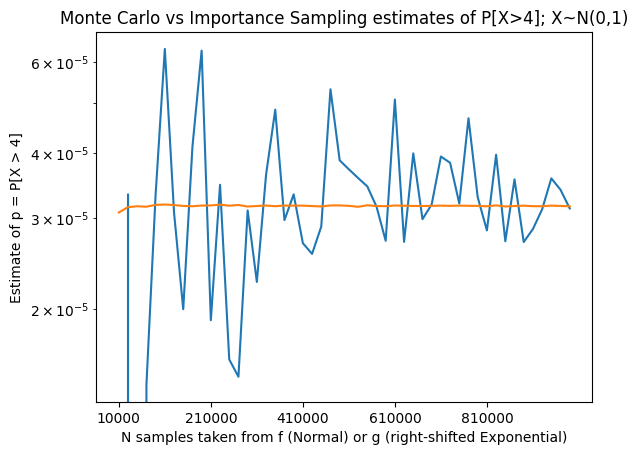

In [155]:
plt.plot(N, MC, linestyle='-')
plt.plot(N, IS, linestyle="-")
plt.xticks(np.arange(10_000, 1_000_001, 200_000))
plt.yscale('log')
plt.title("Monte Carlo vs Importance Sampling estimates of P[X>4]; X~N(0,1)")
plt.xlabel("N samples taken from f (Normal) or g (right-shifted Exponential)")
plt.ylabel("Estimate of p = P[X > 4]")
plt.show()